In [5]:
from copy import deepcopy
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

figures_dir = "/Users/matsen/writing/talks/figures/bcr-mut-sel/"
# if this path does not exist, set it to ""
if not os.path.exists(figures_dir):
    figures_dir = ""

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

In [6]:
# compare_df = pd.read_csv("../train/_ignore/mouse_model_compare.csv")
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
compare_df

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,model,train dataset,training method,seed
0,4600,shmoof_small,0.782566,0.060437,0.027398,-0.115649,0.367453,-1.219108,rsshmoof,tst,yun,0
1,4600,shmoof_small,0.778363,0.056355,0.022541,-0.122682,0.355186,-1.232996,rsshmoof,tst,yun,1


In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# For every row with rsshmoof as the model subtract off 4**5 from the parameter
# count, correspding to every possible 5mer getting mutated to itself. We handle
# this setting indirectly by zeroing out the WT prediction.
df["parameter_count"] = df.apply(lambda row: row["parameter_count"] - 4**5 if row["model"] in ["fivemer", "rsshmoof", "origshmoof"] else row["parameter_count"], axis=1)

# Dictionaries for translation
model_translations = {
    "fivemer": "5mer",
    "rsshmoof": "SHMoof",
    "cnn": "CNN",
    "ind": "Indep",
    "joi": "Joined",
    "hyb": "Hybrid",
    "sml": "Small",
    "med": "Medium",
    "lrg": "Large",
    "4k": "4K"
}

def create_long_name(row):
    parts = row["model"].split('_')
    # Translate each part using the model_translations dictionary
    full_name_parts = [model_translations.get(part, part) for part in parts]
    # Special handling for models without underscores
    if len(full_name_parts) == 1:
        full_name = model_translations.get(row["model"], row["model"])
    else:
        # Join the translated parts with spaces for CNN models
        full_name = ' '.join(full_name_parts[:-1]) + " " + full_name_parts[-1]
    return f"{full_name} ({row['parameter_count']}) {row['training method']}"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

df.head(5)

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,model,train dataset,training method,long_name
16,1082,shmoof_small,0.817020,0.102027,0.051981,-0.056165,0.539730,-0.972237,cnn_joi_sml,shmoof_small,fixed,CNN Joined Small (1082) fixed
18,1082,shmoof_small,0.817825,0.104583,0.052826,-0.068589,0.533052,-0.977333,cnn_joi_sml,shmoof_small,yun,CNN Joined Small (1082) yun
12,1581,shmoof_small,0.818249,0.104004,0.055498,-0.055969,0.537277,-0.975233,cnn_joi_med,shmoof_small,fixed,CNN Joined Medium (1581) fixed
14,1581,shmoof_small,0.818571,0.102540,0.052586,-0.068177,0.532643,-0.972932,cnn_joi_med,shmoof_small,yun,CNN Joined Medium (1581) yun
8,2057,shmoof_small,0.819794,0.104727,0.055177,-0.055849,0.541911,-0.963829,cnn_joi_lrg,shmoof_small,fixed,CNN Joined Large (2057) fixed


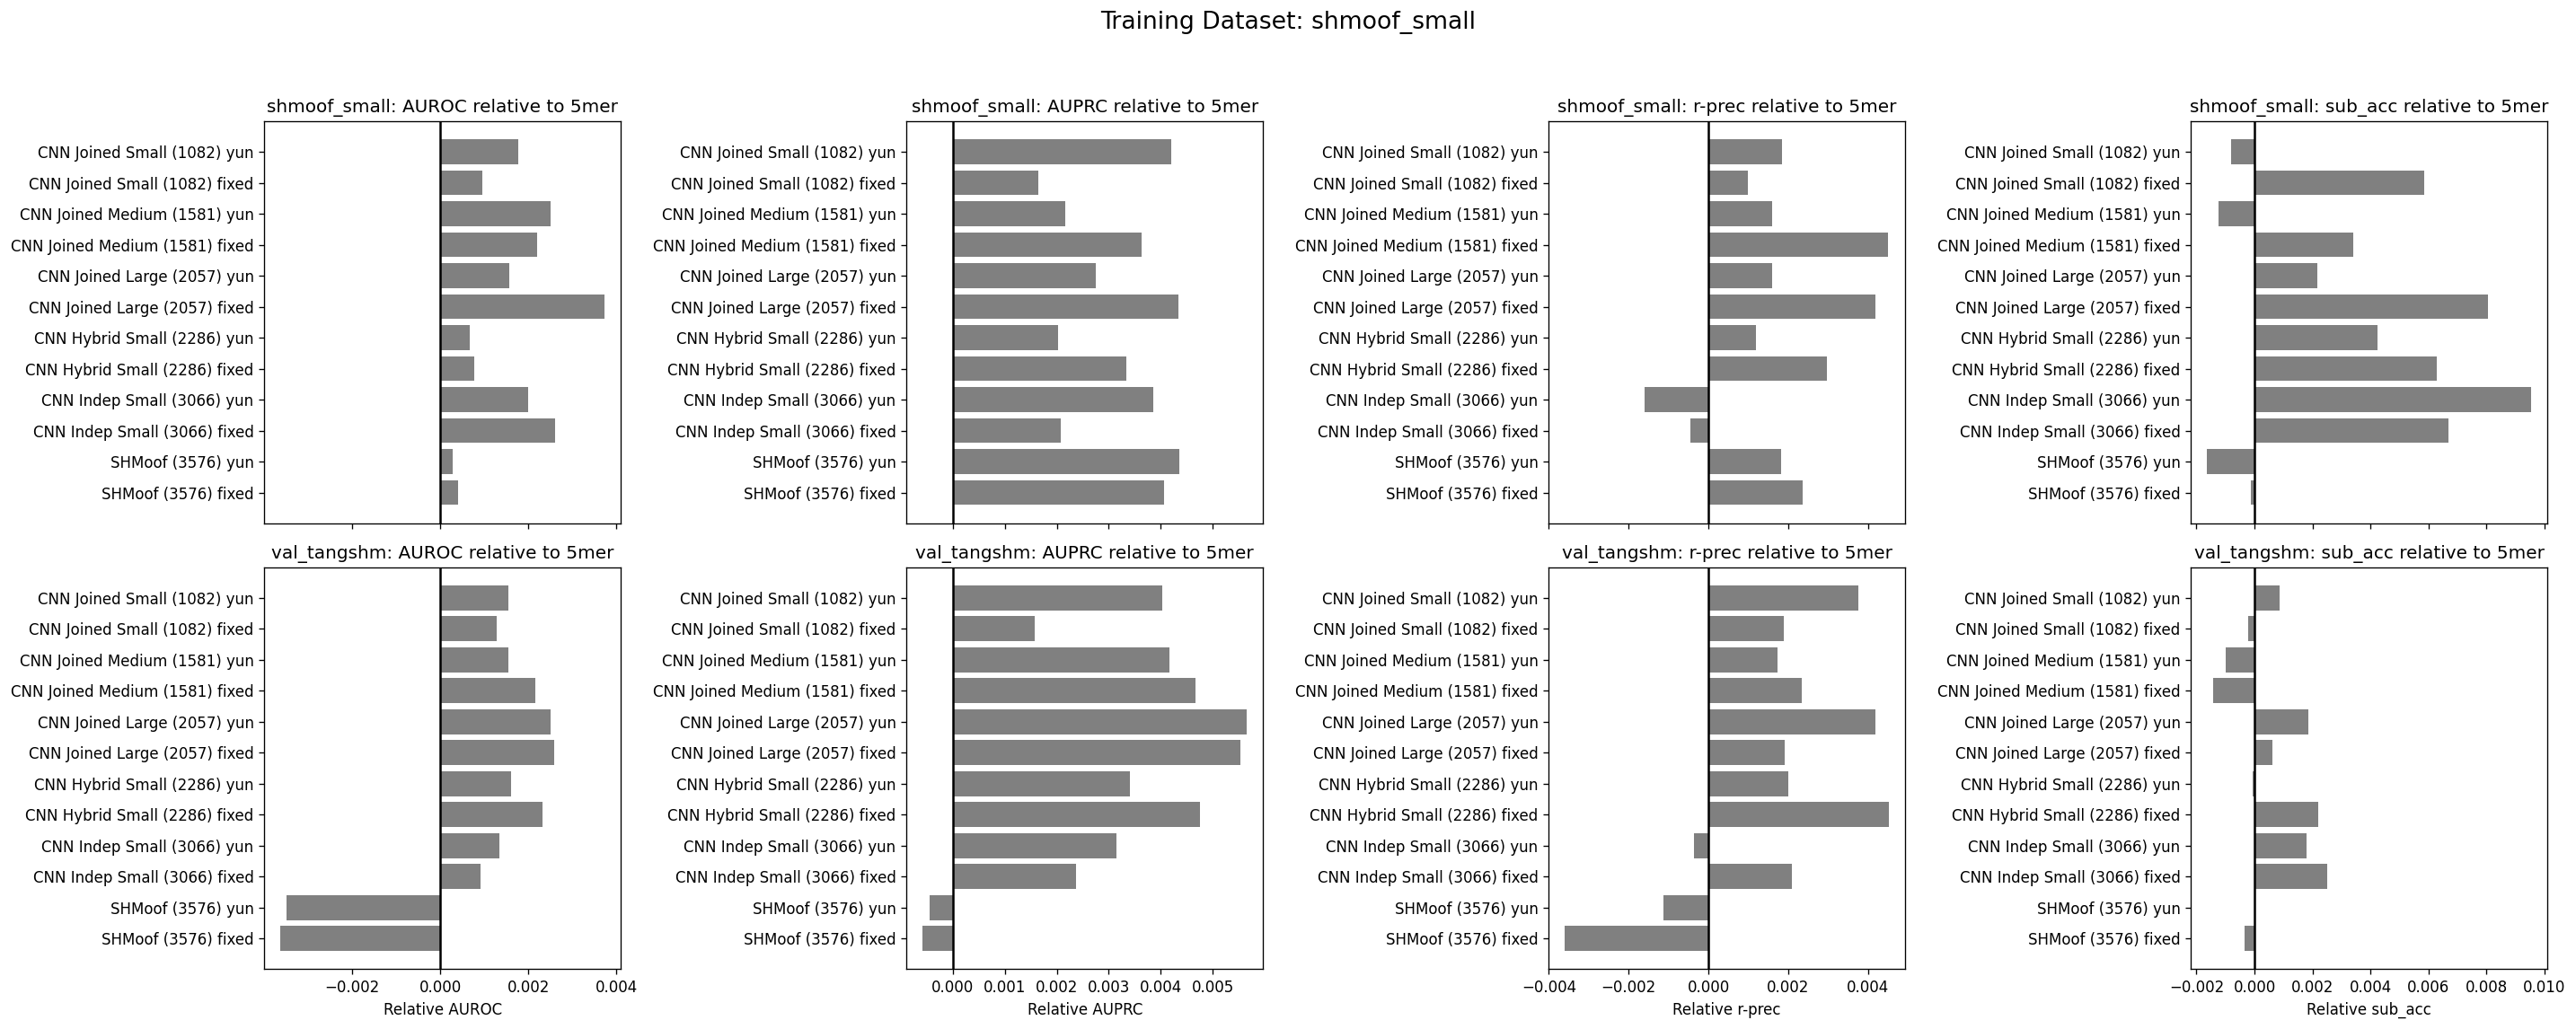

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame
# stats = ['AUROC', 'AUPRC', 'r-prec', 'mut_pos_ll', 'sub_acc', 'base_ll']
stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
train_datasets = df['train dataset'].unique()
test_datasets = df['test dataset'].unique()

# Setup figure parameters, transposing nrows with ncols
nrows = len(test_datasets)
ncols = len(stats)

# Loop through each training dataset to create separate figures or subplot grids
for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows), sharex='col', squeeze=False)
    fig.suptitle(f'Training Dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        # Assuming baseline model filtering remains as you defined
        baseline_values = df_filtered[df_filtered['model'].str.contains('fivemer')].iloc[0]
        
        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered[df_filtered.model != "fivemer"]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]
                ax.barh(df_filtered['long_name'], df_filtered[stat + '_relative'], color='gray')
                ax.set_title(f"{test_dataset}: {stat} relative to 5mer")
                ax.axvline(x=0, color='k')  # Vertical line at 0
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'Relative {stat}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()
